In [18]:
import sklearn
import pandas as pd
import logging
import numpy as np
import sklearn.model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(420)
sklearn.random.seed(420)

## Part 0: Preprocess Dataset

This includes importing, sampling, one hot encoding / normalizing and lastly splitting into train and test data set

In [19]:
data_matrix = pd.read_csv("data.csv")
print("Import Successful")

# Transform Target Matrix
target_matrix = pd.read_csv("flowering_time.csv")
target_matrix = (target_matrix>40).astype(int)
print("Binary Target Variable created")

# 0. Sample 600 rows randomly
np.random.seed(420)

# First, generate indexes of selected rows
indexes = np.random.randint(low = 0, high = len(target_matrix)-1, size = 600).tolist()
print("Random Indexes generated")

sampled_predictors = data_matrix.iloc[indexes,:]
sampled_targets = target_matrix.iloc[indexes,:]
print("Random Rows Selected based on generated indexes")


# Identify categorical and continuous columns
categorical_columns = [categorical for categorical in list(sampled_predictors.columns) if categorical[0] == "g"]
continuous_columns = [categorical for categorical in list(sampled_predictors.columns) if categorical[0] != "g"]  # Replace with your actual continuous column names

# Define transformers for categorical and continuous columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('cont', StandardScaler(), continuous_columns)
    ])

sampled_predictors = preprocessor.fit_transform(sampled_predictors)

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    sampled_predictors,
    sampled_targets,
    train_size = 2/3,
    random_state = 12345)


print("Train Test Split created")

Import Successful
Binary Target Variable created
Random Indexes generated
Random Rows Selected based on generated indexes
Train Test Split created


## Model Nr. 1: Basic Decision Tree Classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

basicTreeClassifier = DecisionTreeClassifier(
    criterion = "entropy",
    splitter = "best",
    #max_depth = 10,
    min_samples_split = 2,
    random_state=42,
    max_depth=10
)

basicTreeClassifier.fit(X=X_train, y=Y_train)

predictions_tree = basicTreeClassifier.predict(X_test)

accuracy_tree = accuracy_score(Y_test, predictions_tree)
confusion_tree = confusion_matrix(Y_test, predictions_tree)
report_tree = classification_report(Y_test, predictions_tree)

print(f"Accuracy: {accuracy_tree:.2f}")
print(f"Confusion Matrix:\n{confusion_tree}")
print(f"Classification Report:\n{report_tree}")

Accuracy: 0.69
Confusion Matrix:
[[93 26]
 [37 44]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       119
           1       0.63      0.54      0.58        81

    accuracy                           0.69       200
   macro avg       0.67      0.66      0.66       200
weighted avg       0.68      0.69      0.68       200



## Model Nr 2: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

randomForest = RandomForestClassifier(
    n_estimators=100, # To Play around with
    criterion="entropy"
)

randomForest.fit(X_train, Y_train.to_numpy().ravel())

predictions_randomforest = randomForest.predict(X_test)

Accuracy: 0.58
Confusion Matrix:
[[95 24]
 [60 21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.80      0.69       119
           1       0.47      0.26      0.33        81

    accuracy                           0.58       200
   macro avg       0.54      0.53      0.51       200
weighted avg       0.55      0.58      0.55       200



## Model 3: XGBosst with adjusted Parameters

In [ ]:
import xgboost
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# https://xgboosting.com/how-to-use-xgboost-xgbclassifier/
XGTree = xgboost.XGBClassifier(
    tree_method = "hist",
    random_state = 420,
    max_depth = 3,
    objective = "binary:logistic",
    eval_metric = "auc",
    n_estimators = 500,
    subsample = 0.9,
    learning_rate = 0.05
)

XGTree.fit(X_train, Y_train)
predictions_xgboost = XGTree.predict(X_test)

Accuracy: 0.76
Confusion Matrix:
[[101  18]
 [ 31  50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.80       119
           1       0.74      0.62      0.67        81

    accuracy                           0.76       200
   macro avg       0.75      0.73      0.74       200
weighted avg       0.75      0.76      0.75       200



## Model 4: Standard Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logModel = LogisticRegression(
    penalty = "l2",
    dual=False,
    random_state=420,
    solver="lbfgs"
)
logModel.fit(X_train, Y_train)

predictions = logModel.predict(X_test)
print(pd.Series(predictions).describe())
predictions_logreg = (predictions > 0.1).astype(int)

count    200.00000
mean       0.22500
std        0.41863
min        0.00000
25%        0.00000
50%        0.00000
75%        0.00000
max        1.00000
dtype: float64
Accuracy: 0.58
Confusion Matrix:
[[95 24]
 [60 21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.80      0.69       119
           1       0.47      0.26      0.33        81

    accuracy                           0.58       200
   macro avg       0.54      0.53      0.51       200
weighted avg       0.55      0.58      0.55       200



c:\UPC\SEMESTER 2\STATISTICAL LEARNING\PART 1\PROJECT\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Model Evaluation

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay

Key Points:
- Evaluate model performance using a confusion matrix.
- Calculate performance metrics including:
    -  Accuracy, Sensitivity, Specificity, and F1-score.
    -  Compare models using ROC curves

### Evaluation 1: Basic Decision Tree Classifier

Confusion Matrix:
[[93 26]
 [37 44]]
Accuracy: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       119
           1       0.63      0.54      0.58        81

    accuracy                           0.69       200
   macro avg       0.67      0.66      0.66       200
weighted avg       0.68      0.69      0.68       200



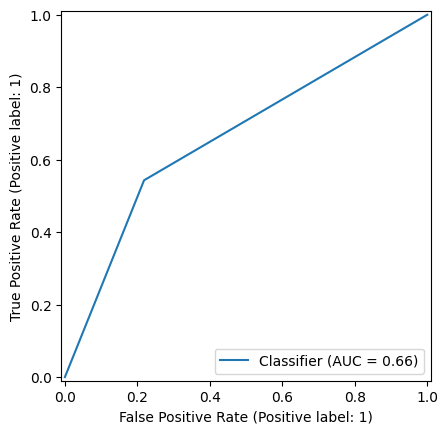

In [26]:
confusion_tree = confusion_matrix(Y_test, predictions_tree)
report_tree = classification_report(Y_test, predictions_tree)
accuracy_tree = accuracy_score(Y_test, predictions_tree)

print(f"Confusion Matrix:\n{confusion_tree}")
print(f"Accuracy: {accuracy_tree:.2f}")
print(f"Classification Report:\n{report_tree}")

RocCurveDisplay.from_predictions(Y_test, predictions_tree)

As we can see, we have an AUC of around 0.66, which is okay, but not great.
The accuracy of 0.69 is mainly due to 37 samples being predicted as 0 although they are indeed 1, which leads our specificity for class 1 to being only 0.54 ...

### Evaluation 2: Random Forest

Accuracy: 0.78
Confusion Matrix:
[[105  14]
 [ 31  50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       119
           1       0.78      0.62      0.69        81

    accuracy                           0.78       200
   macro avg       0.78      0.75      0.76       200
weighted avg       0.78      0.78      0.77       200



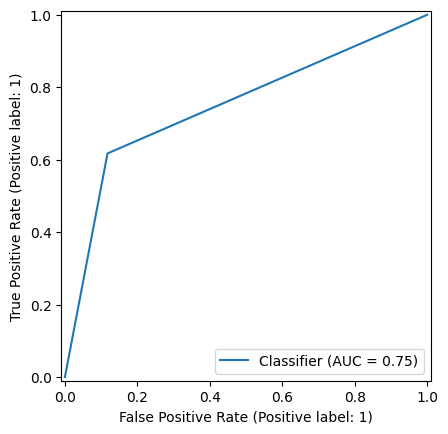

In [27]:
accuracy_randomforest = accuracy_score(Y_test, predictions_randomforest)
confusion_randomforest = confusion_matrix(Y_test, predictions_randomforest)
report_randomforest = classification_report(Y_test, predictions_randomforest)

print(f"Accuracy: {accuracy_randomforest:.2f}")
print(f"Confusion Matrix:\n{confusion_randomforest}")
print(f"Classification Report:\n{report_randomforest}")

RocCurveDisplay.from_predictions(Y_test, predictions_randomforest)

Description of results here

### Evaluation 3: XGBoost

Accuracy: 0.76
Confusion Matrix:
[[101  18]
 [ 31  50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.80       119
           1       0.74      0.62      0.67        81

    accuracy                           0.76       200
   macro avg       0.75      0.73      0.74       200
weighted avg       0.75      0.76      0.75       200



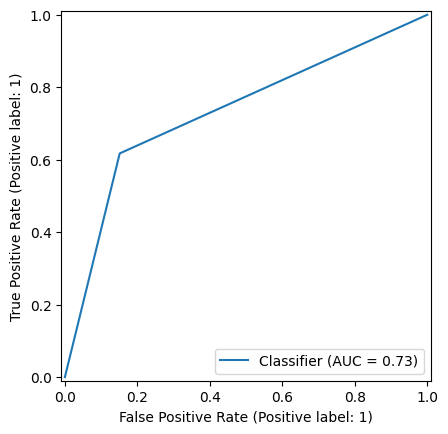

In [28]:
accuracy_xgboost = accuracy_score(Y_test, predictions_xgboost)
confusion_xgboost = confusion_matrix(Y_test, predictions_xgboost)
report_xgboost = classification_report(Y_test, predictions_xgboost)

print(f"Accuracy: {accuracy_xgboost:.2f}")
print(f"Confusion Matrix:\n{confusion_xgboost}")
print(f"Classification Report:\n{report_xgboost}")

RocCurveDisplay.from_predictions(Y_test, predictions_xgboost)

### Evaluation 4: Binary Logistic Regression

Accuracy: 0.58
Confusion Matrix:
[[95 24]
 [60 21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.80      0.69       119
           1       0.47      0.26      0.33        81

    accuracy                           0.58       200
   macro avg       0.54      0.53      0.51       200
weighted avg       0.55      0.58      0.55       200



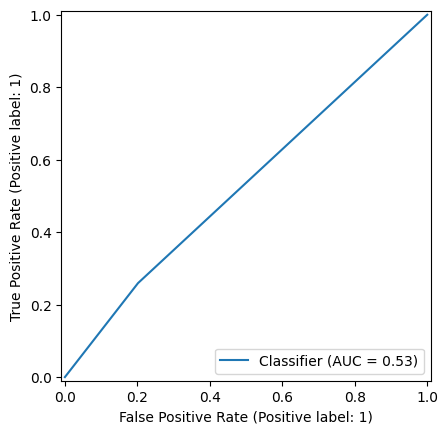

In [29]:
accuracy_logreg = accuracy_score(Y_test, predictions_logreg)
confusion_logreg = confusion_matrix(Y_test, predictions_logreg)
report_logreg = classification_report(Y_test, predictions_logreg)

print(f"Accuracy: {accuracy_logreg:.2f}")
print(f"Confusion Matrix:\n{confusion_logreg}")
print(f"Classification Report:\n{report_logreg}")

RocCurveDisplay.from_predictions(Y_test, predictions_logreg)

## Part 4: Hyperparameter Tuning

### Technique 1: Gridsearch

In [30]:
from sklearn.model_selection import GridSearchCV

### Optimization of Classical Decision Tree

Confusion Matrix:
[[95 24]
 [30 51]]
Accuracy:               precision    recall  f1-score   support

           0       0.76      0.80      0.78       119
           1       0.68      0.63      0.65        81

    accuracy                           0.73       200
   macro avg       0.72      0.71      0.72       200
weighted avg       0.73      0.73      0.73       200

Classification Report:
0.73


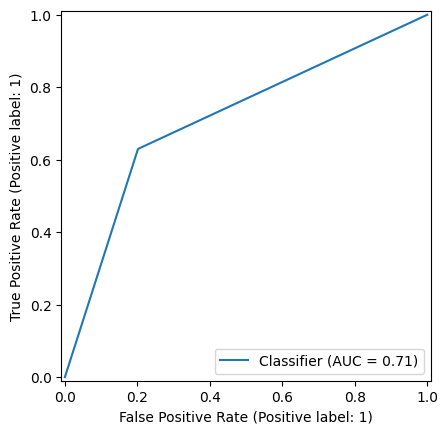

In [34]:
tree = DecisionTreeClassifier()
param_grid = {
    "criterion": ["entropy", "gini", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": [10,20,50,100,250,500]   
}
scoring = "accuracy"

gridSearchedTree = GridSearchCV(
    tree,
    param_grid=param_grid,
    scoring=scoring,
    cv=10 # 10-Fold Cross Validation
)

gridSearchedTree.fit(X_train, Y_train)

best_tree = gridSearchedTree.best_estimator_
predictions_gridsearch_tree = best_tree.predict(X_test)

confusion_gridsearch_tree = confusion_matrix(Y_test, predictions_gridsearch_tree)
report_gridsearch_tree = classification_report(Y_test, predictions_gridsearch_tree)
accuracy_gridsearch_tree = accuracy_score(Y_test, predictions_gridsearch_tree)

print(f"Confusion Matrix:\n{confusion_gridsearch_tree}")
print(f"Accuracy: {report_gridsearch_tree}")
print(f"Classification Report:\n{accuracy_gridsearch_tree}")

RocCurveDisplay.from_predictions(Y_test, predictions_gridsearch_tree)